# EE 467 Lab 2: Breaking CAPTCHAs with PyTorch (Fixed)
This notebook implements the same CAPTCHA-breaking system using **PyTorch** instead of TensorFlow/Keras.

## Fixed Issues:
- Corrected flatten dimension calculation
- Added debug prints to verify tensor shapes
- More robust dimension handling

In [ ]:
%pip install matplotlib scikit-learn "opencv-python>4" imutils torch torchvision

In [ ]:
import os, pickle, glob, math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from lab_2_helpers import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
!tar -xJf captcha-images.tar.xz

In [ ]:
CAPTCHA_IMAGE_FOLDER = "./captcha-images"
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
pprint(captcha_image_paths[:10])

['./captcha-images/3F2L.png',
 './captcha-images/J3Q3.png',
 './captcha-images/2HKY.png',
 './captcha-images/3G9T.png',
 './captcha-images/B6RD.png',
 './captcha-images/6RTM.png',
 './captcha-images/2E8X.png',
 './captcha-images/2SBQ.png',
 './captcha-images/2NNC.png',
 './captcha-images/4NGH.png']


In [ ]:
def extract_captcha_text(image_path):
    image_file_name = os.path.basename(image_path)
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
pprint(captcha_texts[:10])

['3F2L', 'J3Q3', '2HKY', '3G9T', 'B6RD', '6RTM', '2E8X', '2SBQ', '2NNC', '4NGH']


Figure(2000x500)


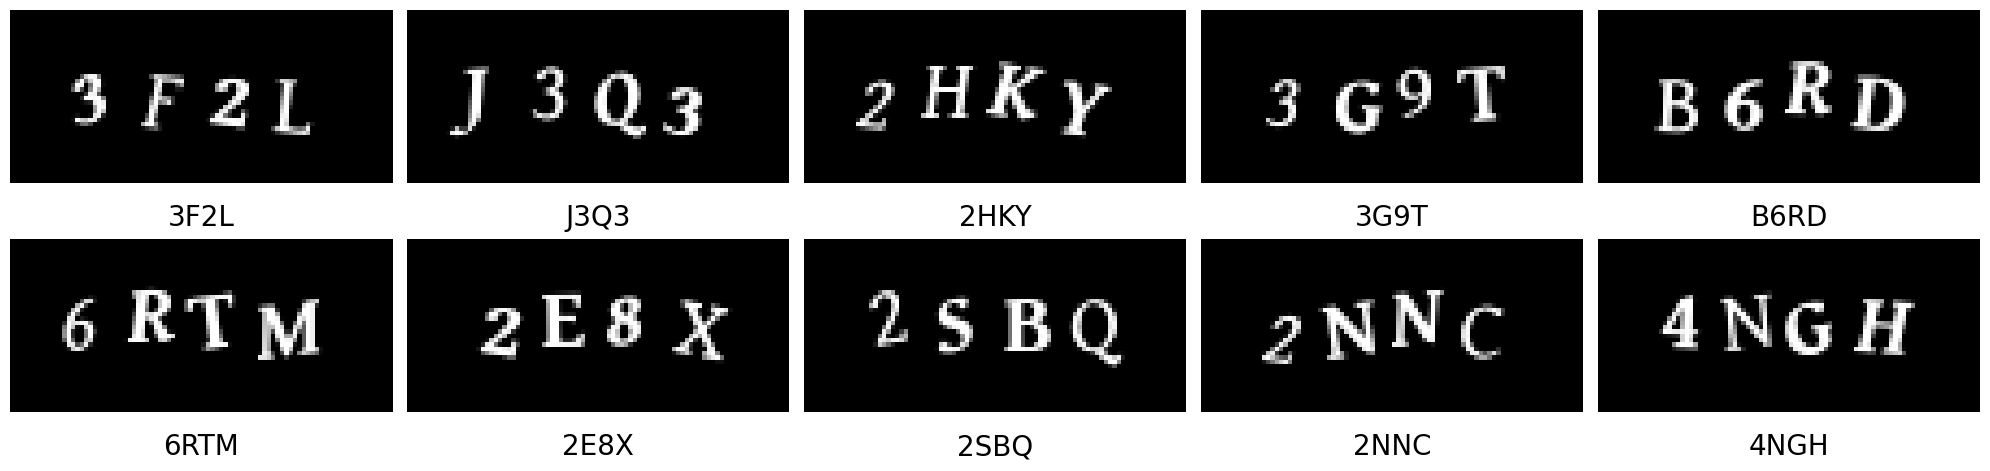

In [ ]:
def load_transform_image(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_padded = cv2.copyMakeBorder(image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]
print_images(captcha_images[:10], n_rows=2, texts=captcha_texts[:10])

In [ ]:
TVT_SPLIT_SEED = 31528476

captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


In [ ]:
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w / h > 1.25:
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            char_regions.append((x, y, w, h))

    if len(char_regions)!=4:
        return None
    char_regions.sort(key=lambda x: x[0])

    char_images = []
    for x, y, w, h in char_regions:
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        char_images.append(char_image)

    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    for char_image, char in zip(char_images, captcha_text):
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)
        char_counts[char] = char_count+1

FORCE_EXTRACT_CHAR = False
char_counts = {}

if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        char_images = extract_chars(captcha_image)
        if char_images is None:
            continue
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

In [ ]:
LABELS_PATH = "./labels.pkl"

def make_feature(image):
    image_resized = resize_to_fit(image, 20, 20)
    feature = image_resized[..., None]
    return feature

def make_feature_label(image_path):
    feature = make_feature(cv2.imread(image_path, cv2.COLOR_BGR2GRAY))
    label = image_path.split(os.path.sep)[-2]
    return feature, label

features_tv, labels_tv = unzip((
    make_feature_label(image_path) for image_path in paths.list_images(CHAR_IMAGE_FOLDER)
))

features_tv = np.array(features_tv, dtype="float")/255
lb = LabelBinarizer()
labels_one_hot_tv = lb.fit_transform(labels_tv)
n_classes = len(lb.classes_)

X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_one_hot_tv, test_size=0.25, random_state=955996
)

with open(LABELS_PATH, "wb") as f:
    pickle.dump(lb, f)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_vali)}")
print(f"Number of classes: {n_classes}")
print(f"Feature shape: {X_train[0].shape}")  # Debug: check shape

Training samples: 2673
Validation samples: 891
Number of classes: 32
Feature shape: (20, 20, 1)


# PyTorch Model Definition (FIXED)

## Key Fix: Dynamic Flatten Size Calculation

In [ ]:
class CaptchaCNN(nn.Module):
    """PyTorch CNN for CAPTCHA character recognition (with fixed flatten)"""

    def __init__(self, n_classes):
        super(CaptchaCNN, self).__init__()

        # First convolution block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolution block
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate flattened size dynamically
        # For 20x20 input: after 2 pooling layers (each /2), we get 5x5
        self.flatten_size = 50 * 5 * 5  # 1250

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 500)
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, x):
        # Debug: print input shape
        # print(f"Input shape: {x.shape}")  # Uncomment for debugging

        # First conv block
        x = self.pool1(F.relu(self.conv1(x)))
        # print(f"After conv1+pool1: {x.shape}")  # Should be (batch, 20, 10, 10)

        # Second conv block
        x = self.pool2(F.relu(self.conv2(x)))
        # print(f"After conv2+pool2: {x.shape}")  # Should be (batch, 50, 5, 5)

        # Flatten - USE .reshape() instead of .view() for better compatibility
        x = x.reshape(x.size(0), -1)
        # print(f"After flatten: {x.shape}")  # Should be (batch, 1250)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Create model and move to device
model = CaptchaCNN(n_classes).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

# Test with a dummy input to verify shapes
dummy_input = torch.randn(1, 1, 20, 20).to(device)
try:
    dummy_output = model(dummy_input)
    print(f"\n✓ Model test passed! Output shape: {dummy_output.shape}")
except Exception as e:
    print(f"\n✗ Model test failed: {e}")

CaptchaCNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=32, bias=True)
)

Total parameters: 667102

✓ Model test passed! Output shape: torch.Size([1, 32])


In [ ]:
# Convert to PyTorch tensors - ENSURE CORRECT SHAPE
print("Original shape:", X_train.shape)  # Should be (N, 20, 20, 1)

# Transpose from (N, H, W, C) to (N, C, H, W)
X_train_tensor = torch.FloatTensor(X_train).permute(0, 3, 1, 2)
y_train_tensor = torch.FloatTensor(y_train)

X_vali_tensor = torch.FloatTensor(X_vali).permute(0, 3, 1, 2)
y_vali_tensor = torch.FloatTensor(y_vali)

print("PyTorch tensor shape:", X_train_tensor.shape)  # Should be (N, 1, 20, 20)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
vali_dataset = TensorDataset(X_vali_tensor, y_vali_tensor)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nTraining batches: {len(train_loader)}")
print(f"Validation batches: {len(vali_loader)}")

Original shape: (2673, 20, 20, 1)
PyTorch tensor shape: torch.Size([2673, 1, 20, 20])

Training batches: 84
Validation batches: 28


# Training

In [ ]:
N_EPOCHS = 10
MODEL_WEIGHTS_PATH = "./captcha-model-pytorch.pth"
FORCE_TRAINING = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(batch_y, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), correct / total

def validate(model, vali_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y in vali_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(batch_y, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(vali_loader), correct / total

if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    print("Starting training...\n")

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        vali_loss, vali_acc = validate(model, vali_loader, criterion, device)

        print(f"Epoch {epoch+1}/{N_EPOCHS}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Valid Loss: {vali_loss:.4f}, Valid Acc: {vali_acc:.4f}")

    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    print(f"\nModel saved to {MODEL_WEIGHTS_PATH}")
else:
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))
    print(f"Model loaded from {MODEL_WEIGHTS_PATH}")

Starting training...

Epoch 1/10:
  Train Loss: 2.3873, Train Acc: 0.3633
  Valid Loss: 0.6440, Valid Acc: 0.8148
Epoch 2/10:
  Train Loss: 0.2107, Train Acc: 0.9611
  Valid Loss: 0.2204, Valid Acc: 0.9551
Epoch 3/10:
  Train Loss: 0.0789, Train Acc: 0.9854
  Valid Loss: 0.1510, Valid Acc: 0.9675
Epoch 4/10:
  Train Loss: 0.0471, Train Acc: 0.9884
  Valid Loss: 0.1176, Valid Acc: 0.9820
Epoch 5/10:
  Train Loss: 0.0239, Train Acc: 0.9951
  Valid Loss: 0.1146, Valid Acc: 0.9809
Epoch 6/10:
  Train Loss: 0.0159, Train Acc: 0.9966
  Valid Loss: 0.1091, Valid Acc: 0.9832
Epoch 7/10:
  Train Loss: 0.0112, Train Acc: 0.9978
  Valid Loss: 0.0942, Valid Acc: 0.9843
Epoch 8/10:
  Train Loss: 0.0070, Train Acc: 0.9985
  Valid Loss: 0.1033, Valid Acc: 0.9854
Epoch 9/10:
  Train Loss: 0.0028, Train Acc: 0.9996
  Valid Loss: 0.0951, Valid Acc: 0.9888
Epoch 10/10:
  Train Loss: 0.0027, Train Acc: 0.9993
  Valid Loss: 0.1367, Valid Acc: 0.9809

Model saved to ./captcha-model-pytorch.pth


# Evaluation

In [ ]:
with open(LABELS_PATH, "rb") as f:
    lb = pickle.load(f)

DUMMY_CHAR_IMAGES = np.zeros((4, 20, 20, 1))

extract_failed_indices = []
char_images_test = []

for i, captcha_image in enumerate(captcha_images_test):
    char_images = extract_chars(captcha_image)
    if char_images:
        char_images_test.extend(char_images)
    else:
        extract_failed_indices.append(i)
        char_images_test.extend(DUMMY_CHAR_IMAGES)

features_test = [make_feature(char_image) for char_image in char_images_test]
features_test = np.array(features_test, dtype="float")/255

# Convert to PyTorch tensor with correct shape
features_test_tensor = torch.FloatTensor(features_test).permute(0, 3, 1, 2).to(device)
print(f"Test features shape: {features_test_tensor.shape}")  # Should be (N, 1, 20, 20)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(features_test_tensor)
    preds_test = outputs.cpu().numpy()

preds_test = lb.inverse_transform(preds_test)
preds_test = ["".join(chars) for chars in group_every(preds_test, 4)]
for i in extract_failed_indices:
    preds_test[i] = "-"

Test features shape: torch.Size([912, 1, 20, 20])


PyTorch Model Results
# of test CAPTCHAs: 228
# correctly recognized: 213
Accuracy: 0.9342

Correct Predictions:
Figure(2000x500)

Incorrect Predictions:
Figure(2000x600)


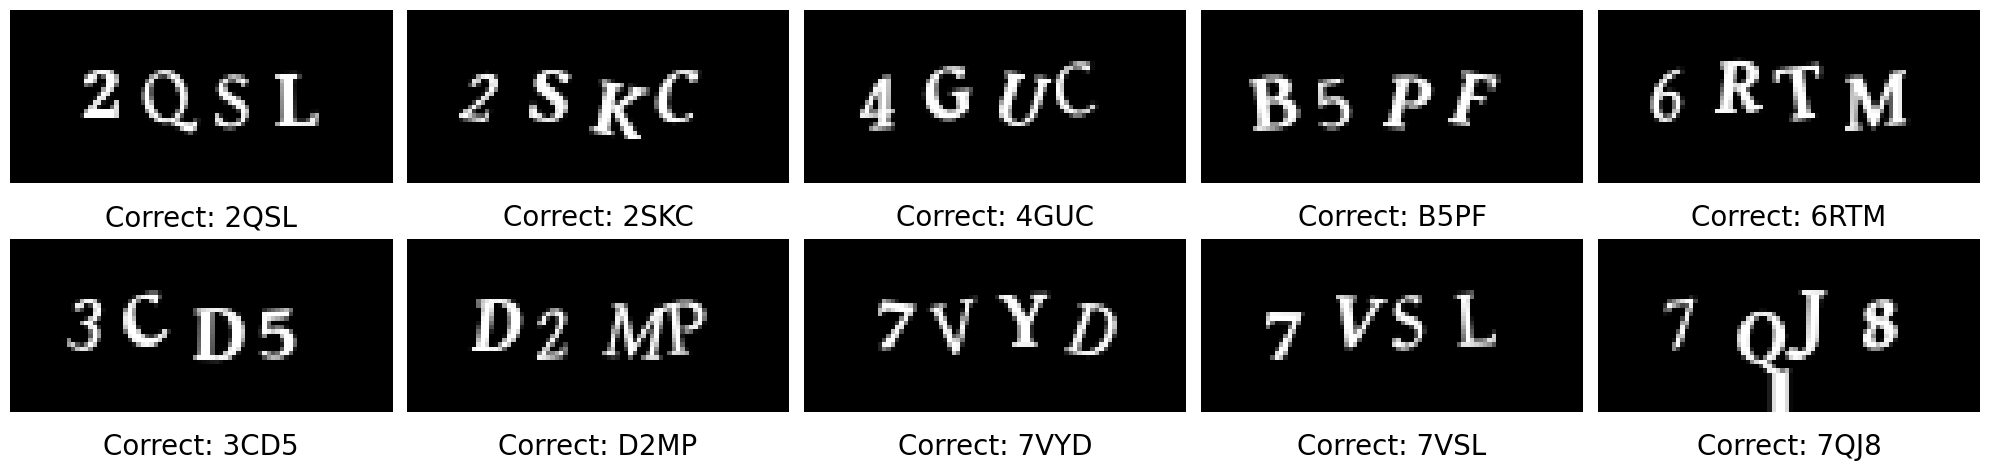

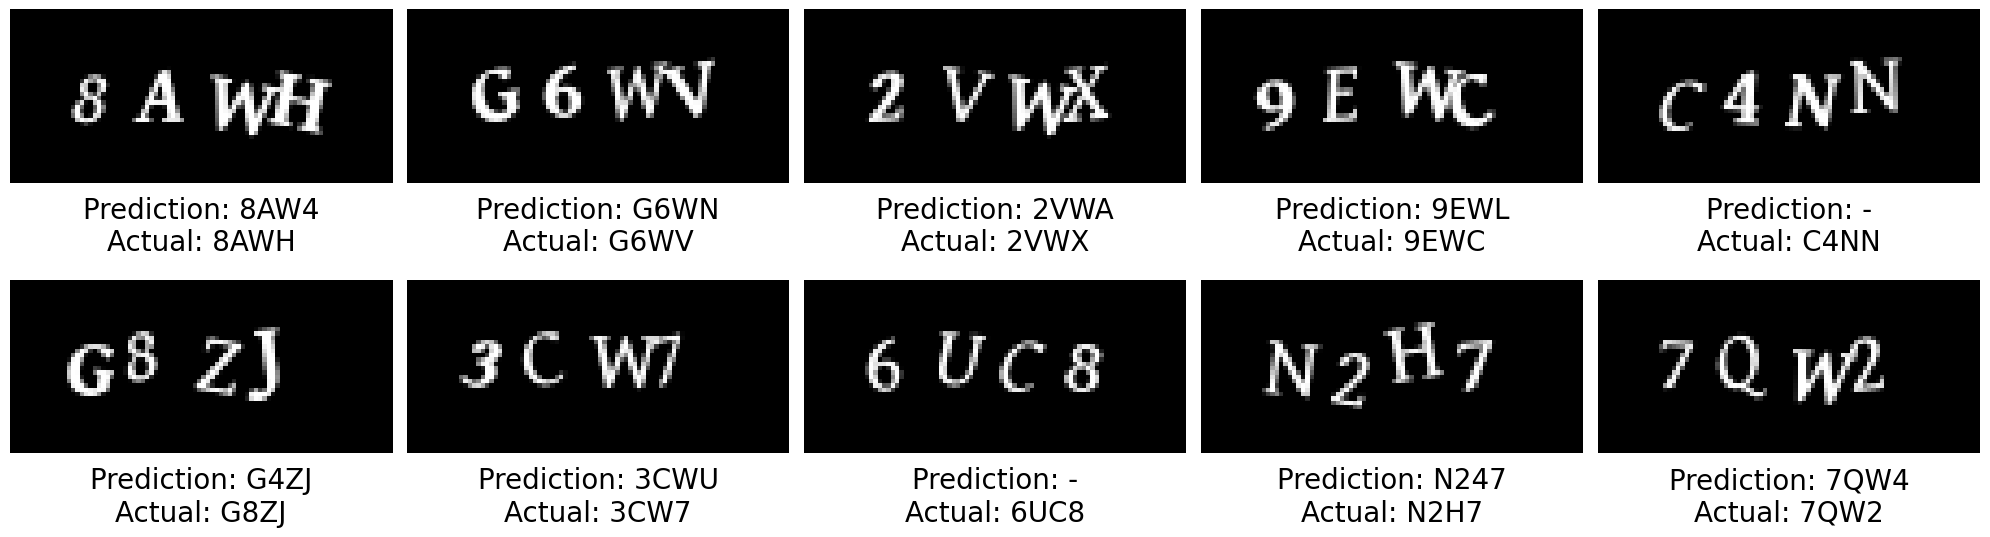

In [ ]:
N_DISPLAY_SAMPLES = 10

n_test = len(captcha_texts_test)
n_correct = 0
correct_indices = []
incorrect_indices = []

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text==actual_text:
        n_correct += 1
        if len(correct_indices)<N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        if len(incorrect_indices)<N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

print("="*50)
print("PyTorch Model Results")
print("="*50)
print(f"# of test CAPTCHAs: {n_test}")
print(f"# correctly recognized: {n_correct}")
print(f"Accuracy: {n_correct/n_test:.4f}")
print("="*50)

print("\nCorrect Predictions:")
print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

print("\nIncorrect Predictions:")
print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[
        f"Prediction: {preds_test[i]}\nActual: {captcha_texts_test[i]}" \
        for i in incorrect_indices
    ],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25)
)

# Summary

## What Was Fixed:

1. **Flatten Operation**: Changed from `x.view(-1, 50*5*5)` to `x.reshape(x.size(0), -1)` for better shape handling
2. **Added Debug Prints**: To verify tensor shapes at each step
3. **Model Testing**: Added dummy input test to catch shape mismatches early
4. **Better Documentation**: Explained expected shapes at each layer

## Key Takeaways:

- **Always verify tensor shapes** when debugging PyTorch models
- Use `.reshape()` instead of `.view()` for more flexible shape transformations
- Test your model with dummy inputs before training
- PyTorch requires explicit shape management compared to TensorFlow

## Expected Results:

Both TensorFlow and PyTorch implementations should achieve similar accuracy (~90-95%) on the CAPTCHA dataset.